# Accumulator payoff pricing using analytical distribution for barrier and gearing strike hit.

We consider that the underlyign equity follows an exponntial Brownian movement, and hence its log returns can be model is a normal distribution: 
$$
 \frac{\Delta S}{S} = \mu \delta T + \sigma( S,t )\sqrt{t}\Delta Z_t 
$$

Under this stochastic process the following probabilies expression hold:
1. Probability of hitting a Down trigger 
$ P_{hit}= P(S \le BL) = \Phi( \frac{\log{BL} - \mu T}{\sigma \sqrt{T}})$
<br/><br/>
2. Probability of hitting a Up trigger 
$ P_{hit}= P(S \ge BL) = 1.0 - \Phi( \frac{\log{BL} - \mu T}{\sigma \sqrt{T}})$
<br/><br/>
In the context of modelling an accumulator payoff with KO and gearing features, both events can be mapped to a barrier trigger affecting the number of equities accumulator over the future time horizon.

In [420]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import  matplotlib.pyplot as plt

 # $ P(S \le BL) $

In [421]:
#P(S <= BL)
def p_hit(T,sigma,S,BL, mu):
    H = BL/S
    x = np.log(H)-mu*T
    sT = sigma*np.sqrt(T)
    return norm.cdf(x/sT)


# $P(\tau \le T)$

In [422]:
def p_hit_before_time(T,sigma,S,K, mu):    
    H = K/S    
    if H>1:
        H = 1.0/H
        mu=-mu
        tmp = S
        S=K
        K=tmp
        
    lnK = np.log(H)
    s2 = sigma**2
    sqrtT = np.sqrt(T)
    sigma05T = sigma*sqrtT
    num = np.exp(2*mu*lnK/s2)*norm.cdf((lnK+mu*T)/sigma05T)
    den = norm.cdf((lnK-mu*T)/sigma05T)+1e-12
    return (1+num/(den))*p_hit(T,sigma,S,K,mu)


# $p(\tau = T)$

In [423]:
def p_hit_in_t(T,sigma,S,K, mu):
    H = K/S    
    if H>1:
        H = 1.0/H
        mu=-mu
        tmp = S
        S=K
        K=tmp
        
    dt = 1.0/260.0
    a = p_hit_before_time(T+dt,sigma,S,K, mu)
    b = p_hit_before_time(T-dt,sigma,S,K, mu)

    return (a-b)/(2*dt)

# Accumulator Payoff with only Gearing Events
<br>
We study the case of an accumulator with a down gear strike level, $H_{gear}$, which increases the number of accumlated shares per day $\eta$ by a factor g while the spot stays below this trigger level.

$$V(t) = \sum \limits_{i=1}^{N} \eta \times (1+ g \times P(S \le H_{gear}))  $$

# Example Accumulator gearing and without KO
- S=100
- $H_{gear} = 98$
- $ \eta = 1 \times \frac{shares}{day}$
- $ \mu = 0.0 $
- $ T= 1y$
- $\sigma = 45\%$

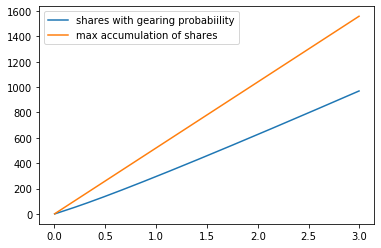

In [424]:
sigma = 0.45/np.sqrt(260.0)
t = np.array(range(1,3*260))/260.0
dt = t[1]-t[0]
S=100.0
K=98.0
shares_per_day = 1
gearing = 1.0
shares_Accumulator_Each_day = [shares_per_day*(1+gearing*p_hit(i,sigma,S,K,0.0))  for i in t]
max_shares_Accumulator_Each_per_day = [shares_per_day*(1+gearing)  for i in t]
max_shares_Accumulator_Each_day = np.cumsum([shares_per_day*(1+gearing)  for i in t])
total_accumulated_shares = np.cumsum(shares_Accumulator_Each_day)
plt.plot(t,total_accumulated_shares,label="shares with gearing probabiility")
plt.plot(t,max_shares_Accumulator_Each_day,label="max accumulation of shares")
plt.legend()

plt.show()

The picture above depicts the difference in between the full share accumulation assumption (over consevative) vs the gearing with hit probability. 

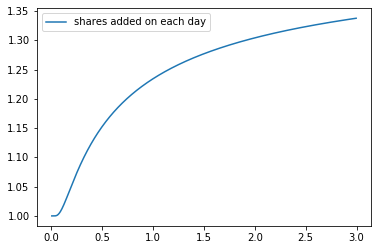

In [425]:
plt.plot(t,shares_Accumulator_Each_day,label="shares added on each day")

plt.legend()
plt.show()

The curve above depicts the number of shares accumulated per day as the time passess. Since no drift is considered on the stock model, $\mu = 0$, to the 1 shares per day standard accumulation, the gearing adds one extra share with probability $P(S\le H_{gear})$. When $t \to \infty$, the probability of hiting the gearing level tends to 50\%, meaning approximates to 1.5 shares per day as time tends to $\infty$.

# Accumulator Payoff with  Gearing and KO Events
<br>
We include the KO probability over time togethe with the feature already presented in the previous simulation. 

In the current simulations the accumulation of shares is conditioned to the fact that the stock has not reached the KO barrier level $BL_{KO}$.


The probability of not being KO at time $\tau$ is simply defined as $P(\tau \ge T) = 1 - P(\tau \le T) $, and the new expression of the accumulated number of shares at the maturity is:
$$V(T) = \sum \limits_{i=1}^{N} \eta \times (1+ g \times P(S \le H_{gear},t_i))\times P(\tau > t_i)  $$

# Example Accumulator gearing and  KO
- S=100
- $H_{gear} = 98$
- $ \eta = 1 \times \frac{shares}{day}$
- $ \mu = 0.0 $
- $ T= 1y$
- $\sigma = 45\%$
- $BL_{KO}=102$

In [426]:
sigma = 0.45/np.sqrt(260.0)
t = np.array(range(1,5*260))/260.0
dt = t[1]-t[0]
S=100.0
K=98.0
shares_per_day = 1
gearing = 1.0
BL_KO=102
mu=0.0





The figure below depicts the probability of knocking out the up barrier over time. As $t \to \infty$ the $P(S\ge BL_{KO}) \to \frac{1}{2})$

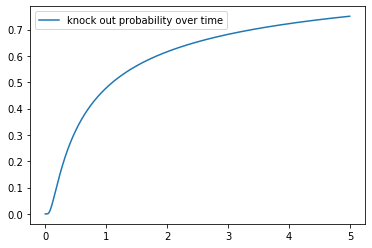

In [427]:
p_ko_t = [(p_hit_before_time(i,sigma,S,BL_KO,mu))  for i in t]
plt.plot(t,p_ko_t, label="knock out probability over time")
plt.legend()

The number of shares accumulated each day with and without KO feature is  depicted in the figure below

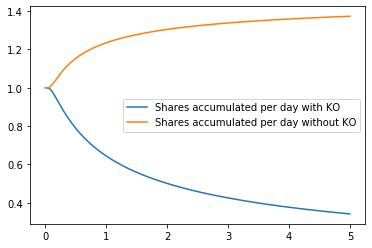

In [428]:
shares_Accumulator_Each_day_with_KO = [shares_per_day*(1+gearing*p_hit(i,sigma,S,K,0.0))*(1.0-p_hit_before_time(i,sigma,S,BL_KO, mu))  for i in t]
shares_Accumulator_Each_day_without_KO = [shares_per_day*(1+gearing*p_hit(i,sigma,S,K,0.0))  for i in t]

plt.plot(t,shares_Accumulator_Each_day_with_KO,label="Shares accumulated per day with KO")
plt.plot(t,shares_Accumulator_Each_day_without_KO,label="Shares accumulated per day without KO")
plt.legend()

The total number of share accumulated with and without KO feature is depicted in the figure below

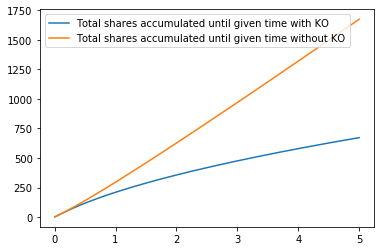

In [429]:
total_shares_Accumulator_Each_day_with_KO = np.cumsum(shares_Accumulator_Each_day_with_KO)
total_shares_Accumulator_Each_day_without_KO = np.cumsum(shares_Accumulator_Each_day_without_KO)

plt.plot(t,total_shares_Accumulator_Each_day_with_KO,label="Total shares accumulated until given time with KO")
plt.plot(t,total_shares_Accumulator_Each_day_without_KO,label="Total shares accumulated until given time without KO")
plt.legend()

# Accumulation simulation on S&P500

- S=4,509.37
- $H_{gear} = 4283.9$
- $ \eta = 200 \times \frac{shares}{day}$
- $ \mu = 0.0 $
- $ T= 1y$
- $\sigma = 16\%$
- $BL_{KO}=4734.8$
- VaR Factor = 35\% $\times \sqrt{\frac{10}{260}}$

In [430]:
year_sigma = 0.16
sigma = year_sigma/np.sqrt(260.0)
t = np.array(range(1,260))/260.0
dt = t[1]-t[0]
S=4509.37
K=S*(1-0.05)
shares_per_day = 5
gearing = 1.0
BL_KO=S*(1+0.1)
mu=0.0
VaR_factor = 2.32*year_sigma*np.sqrt(10/260)
Sup = S*(1+VaR_factor)
Sdown = S*(1-VaR_factor)
print("VaR="+str(VaR_factor))
print("S="+str(S))
print("Sup="+str(Sup))
print("Sdown="+str(Sdown))

VaR=0.07279830936329391
S=4509.37
Sup=4837.6445122935565
Sdown=4181.095487706443


Three simulation are performed to compute the up and down addons, namely:
- Base Line simulation, $shares_{baseline}$, corresponding the the accumulated number of shares until maturity assuming the calculation date spot.
- Up Addon accumulated shares, $shares_{up}$, which is the accumulated number of shares for a shocked spot $S_{up}=S\times (1+VaR)$
- Down Addon accumulated shares, $shares_{down}$, which is the accumulated number of shares for a shocked spot $S_{down}=S\times (1-VaR)$ 

The up and down monetary addons are computed as follows:

- $UA = (shares_{up} - shares_{baseline}) \times S \times VaR$
- $DA = (shares_{down} - shares_{baseline}) \times S \times -VaR$

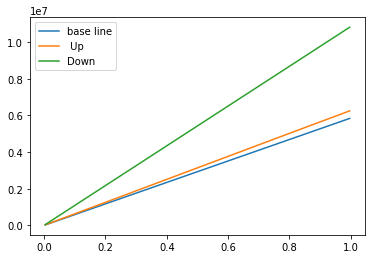

In [431]:
base_addon_daily = S*np.cumsum([shares_per_day*(1+gearing*p_hit(i,sigma,S,K,0.0))*(1.0-p_hit_before_time(i,sigma,S,BL_KO, mu))  for i in t])
Up_Addon_daily = Sup*np.cumsum([shares_per_day*(1+gearing*p_hit(i,sigma,Sup,K,0.0))*(1.0-p_hit_before_time(i,sigma,Sup,BL_KO, mu))  for i in t])
Down_Addon_daily = Sdown * np.cumsum([shares_per_day*(1+gearing*p_hit(i,sigma,Sdown,K,0.0))*(1.0-p_hit_before_time(i,sigma,Sdown,BL_KO, mu))  for i in t])

plt.plot(t,base_addon_daily, label="base line")
plt.plot(t,Up_Addon_daily, label=" Up")
plt.plot(t,Down_Addon_daily, label="Down")
plt.legend()


For the case of the Up Addon, the differential number of shares with respect to the base line is negative, since when the stock experiments a positive shock around 6\%, the probability of knocking out the instrument increases reducing the estimated number of shares at maturity.

The down shock instead generates a lower probability of KO but at the same time an increased gearing probability, as the stock is closer to the gearing strike level. 

In the later situation, the differential number of shares with respect to the base line is possitive and is depicted as the 'Down' curve in the figure above.

From a risk perspective, we conly consider in this Accumulator payoff the positive differential of shares with respect to the baseline, choosing then the down shock as the selected one.

UA=0.4113112863921989
DA=4.981730184166593


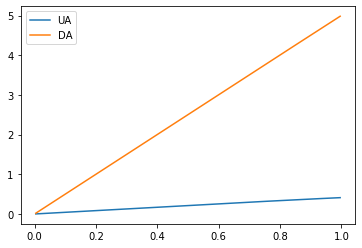

In [432]:
UA = Up_Addon_daily - base_addon_daily
DA = Down_Addon_daily - base_addon_daily
plt.plot(t,UA/1e6, label="UA")
plt.plot(t,DA/1e6, label="DA")
plt.legend()
print("UA="+str(UA[-1]/1e6))
print("DA="+str(DA[-1]/1e6))

The increase losses incurred for a down shock of value $S\times (1-VaR)$ is 5 millions.
